In [83]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
engine = author.raw_engine

In [84]:
df = pd.read_sql("SELECT * FROM BTCUSD_5m",engine)
df.set_index('Datetime',inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-12-30 15:00:00,47428.351562,47428.351562,47390.437500,47407.894531,47407.894531,0
2021-12-30 15:05:00,47369.851562,47476.515625,47369.851562,47476.515625,47476.515625,0
2021-12-30 15:10:00,47469.585938,47496.976562,47441.757812,47441.757812,47441.757812,0
2021-12-30 15:15:00,47462.195312,47501.437500,47430.824219,47430.824219,47430.824219,0
2021-12-30 15:20:00,47499.777344,47499.777344,47449.773438,47449.773438,47449.773438,20891648
...,...,...,...,...,...,...
2022-02-28 14:20:00,38692.250000,38729.339844,38692.250000,38729.339844,38729.339844,585838592
2022-02-28 14:25:00,38771.296875,38771.296875,38762.097656,38762.097656,38762.097656,209033216
2022-02-28 14:30:00,38850.421875,39182.421875,38850.421875,39182.421875,39182.421875,627218432


<AxesSubplot:>

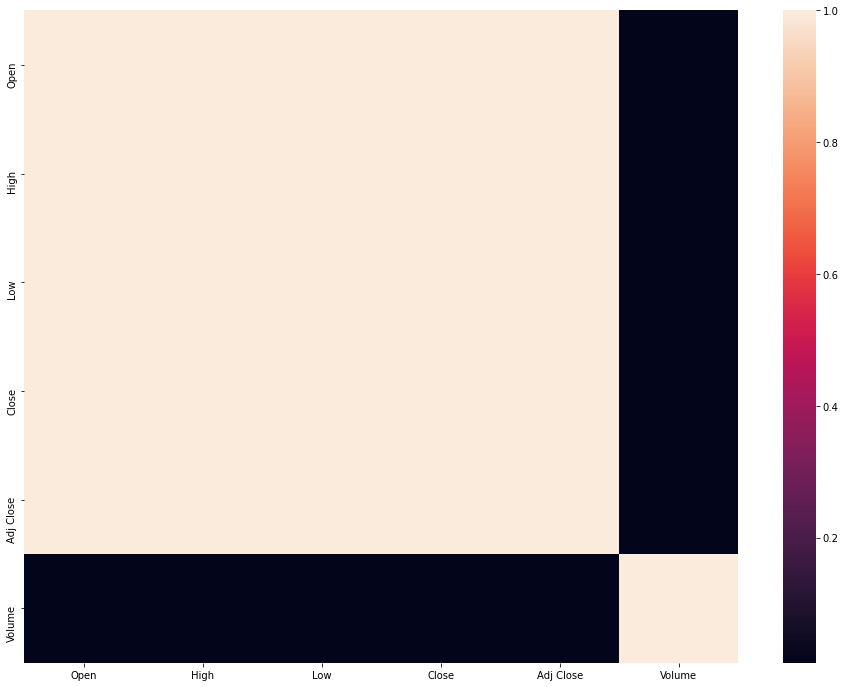

In [85]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr())

o,h,l,c는 실상 동일하므로 피쳐를 조합해 새로운 피쳐를 만들어준다.

In [86]:
gap = (df['High'] - df['Low'])
df['Gap'] = gap
df

,Open,High,Low,Close,Adj Close,Volume,Gap
Datetime,,,,,,,
2021-12-30 15:00:00,47428.351562,47428.351562,47390.437500,47407.894531,47407.894531,0,37.914062
2021-12-30 15:05:00,47369.851562,47476.515625,47369.851562,47476.515625,47476.515625,0,106.664062
2021-12-30 15:10:00,47469.585938,47496.976562,47441.757812,47441.757812,47441.757812,0,55.218750
2021-12-30 15:15:00,47462.195312,47501.437500,47430.824219,47430.824219,47430.824219,0,70.613281
2021-12-30 15:20:00,47499.777344,47499.777344,47449.773438,47449.773438,47449.773438,20891648,50.003906
...,...,...,...,...,...,...,...
2022-02-28 14:20:00,38692.250000,38729.339844,38692.250000,38729.339844,38729.339844,585838592,37.089844
2022-02-28 14:25:00,38771.296875,38771.296875,38762.097656,38762.097656,38762.097656,209033216,9.199219
2022-02-28 14:30:00,38850.421875,39182.421875,38850.421875,39182.421875,39182.421875,627218432,332.000000


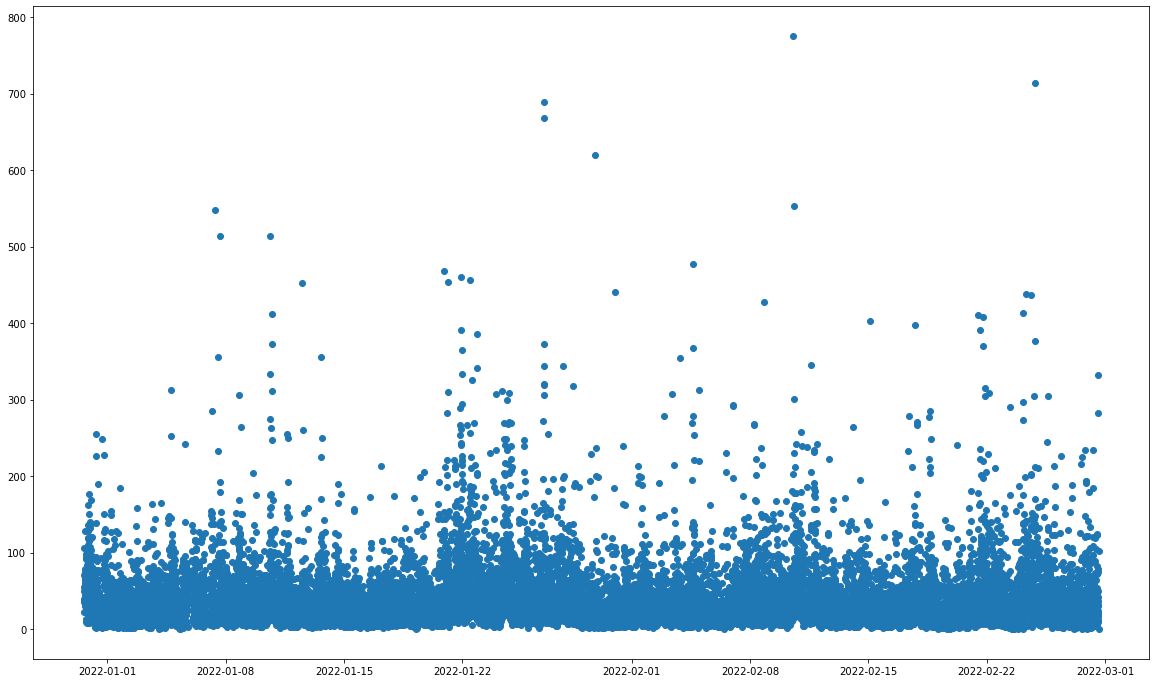

In [87]:
plt.figure(figsize=(20,12))
plt.scatter(df['Gap'].index, df['Gap'])

값이 커짐에 따라 변동폭도 증가하므로 명확한 아웃라이어를 보기위해 비트코인의 가격 상승을 반영해준다.

In [88]:
df['Gap'] = df['Gap'] / df['Low']

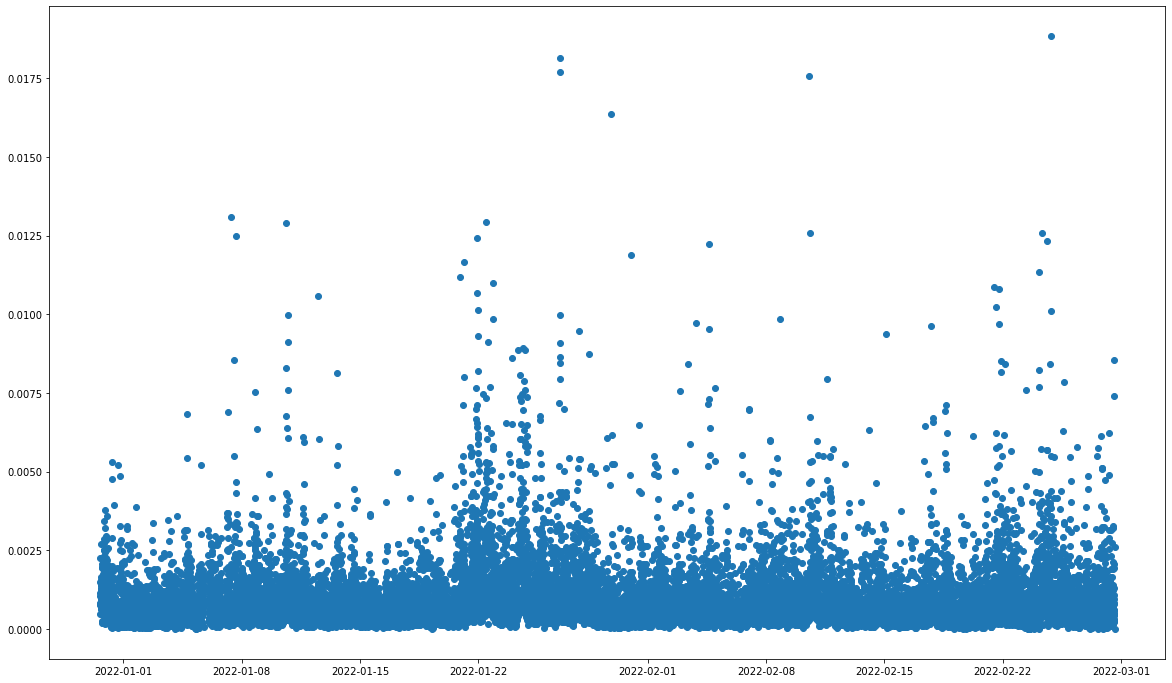

In [89]:
plt.figure(figsize=(20,12))
plt.scatter(df['Gap'].index, df['Gap'])

In [90]:
def get_macd(df):
    price = df['Adj Close']
    exp12 = price.ewm(span = 12, adjust=False).mean()
    exp26 = price.ewm(span = 26, adjust=False).mean()
    macd = exp12 - exp26
    exp = macd.ewm(span=9,adjust=False).mean()
    return exp

def get_rsi(df, period):
    close_price = df['Close']
    delta = close_price.diff()
    gains,drops = delta.copy(),delta.copy()
    gains[gains < 0] = 0
    drops[drops > 0] = 0
    au = gains.ewm(com=period-1, min_periods=period).mean()
    ad = drops.abs().ewm(com=period-1, min_periods=period).mean()
    rs = au / ad
    rsi = pd.Series(100 - (100 / (1 + rs)))
    return rsi

def get_vwap(df):
    volumes = df['Volume']
    price = df['Adj Close']
    vwap = ((volumes * price).cumsum()) / volumes.cumsum()
    return vwap

In [91]:
df['VWAP'] = get_vwap(df)
df['RSI'] = get_rsi(df,7)
df['MACD'] = get_macd(df)
df

,Open,High,Low,Close,Adj Close,Volume,Gap,VWAP,RSI,MACD
Datetime,,,,,,,,,,
2021-12-30 15:00:00,47428.351562,47428.351562,47390.437500,47407.894531,47407.894531,0,0.000800,NaN,NaN,0.000000
2021-12-30 15:05:00,47369.851562,47476.515625,47369.851562,47476.515625,47476.515625,0,0.002252,NaN,NaN,1.094809
2021-12-30 15:10:00,47469.585938,47496.976562,47441.757812,47441.757812,47441.757812,0,0.001164,NaN,NaN,2.261397
2021-12-30 15:15:00,47462.195312,47501.437500,47430.824219,47430.824219,47430.824219,0,0.001489,NaN,NaN,3.232225
2021-12-30 15:20:00,47499.777344,47499.777344,47449.773438,47449.773438,47449.773438,20891648,0.001054,47449.773438,NaN,4.324420
...,...,...,...,...,...,...,...,...,...,...
2022-02-28 14:20:00,38692.250000,38729.339844,38692.250000,38729.339844,38729.339844,585838592,0.000959,42017.007930,87.806838,-47.467648
2022-02-28 14:25:00,38771.296875,38771.296875,38762.097656,38762.097656,38762.097656,209033216,0.000237,42016.367907,88.407687,-28.797843
2022-02-28 14:30:00,38850.421875,39182.421875,38850.421875,39182.421875,39182.421875,627218432,0.008546,42014.696835,93.328840,-1.000733


In [92]:
df = df.dropna()
df = df.drop(['Open','Close','High','Low'], axis=1)
df


,Adj Close,Volume,Gap,VWAP,RSI,MACD
Datetime,,,,,,
2021-12-30 15:35:00,47307.085938,0,0.000752,47449.773438,22.185903,-0.321587
2021-12-30 15:40:00,47343.250000,569344,0.000730,47446.947451,37.202048,-3.141865
2021-12-30 15:45:00,47323.187500,0,0.000852,47446.947451,33.071491,-6.128447
2021-12-30 15:50:00,47281.406250,0,0.001663,47446.947451,26.045373,-9.715333
2021-12-30 15:55:00,47210.312500,0,0.001255,47446.947451,18.319193,-14.602563
...,...,...,...,...,...,...
2022-02-28 14:20:00,38729.339844,585838592,0.000959,42017.007930,87.806838,-47.467648
2022-02-28 14:25:00,38762.097656,209033216,0.000237,42016.367907,88.407687,-28.797843
2022-02-28 14:30:00,39182.421875,627218432,0.008546,42014.696835,93.328840,-1.000733


<AxesSubplot:>

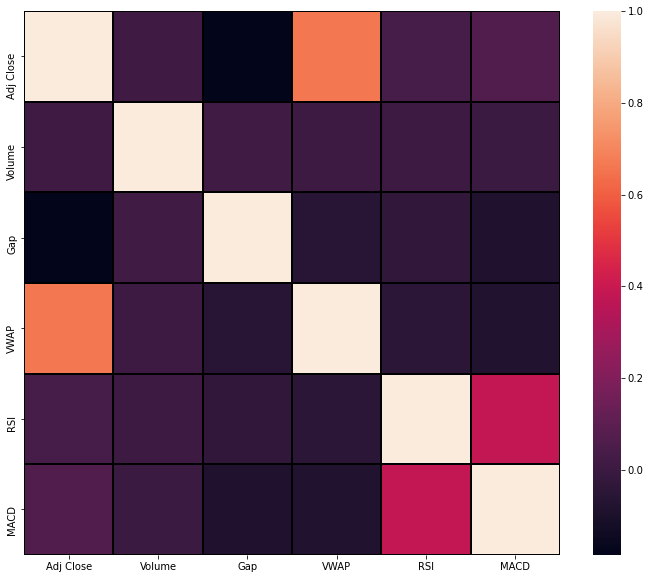

In [93]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),linewidth=1,linecolor='black')

vwap와 rsi가 음의 상관관계를 띄는 것을 확인할 수 있다. 또한 gap은 volume과 양의 상관 관계를 띄는데 이로써 거래량이 튀면 고점이 증가한다는 것을 확인할 수 있다.

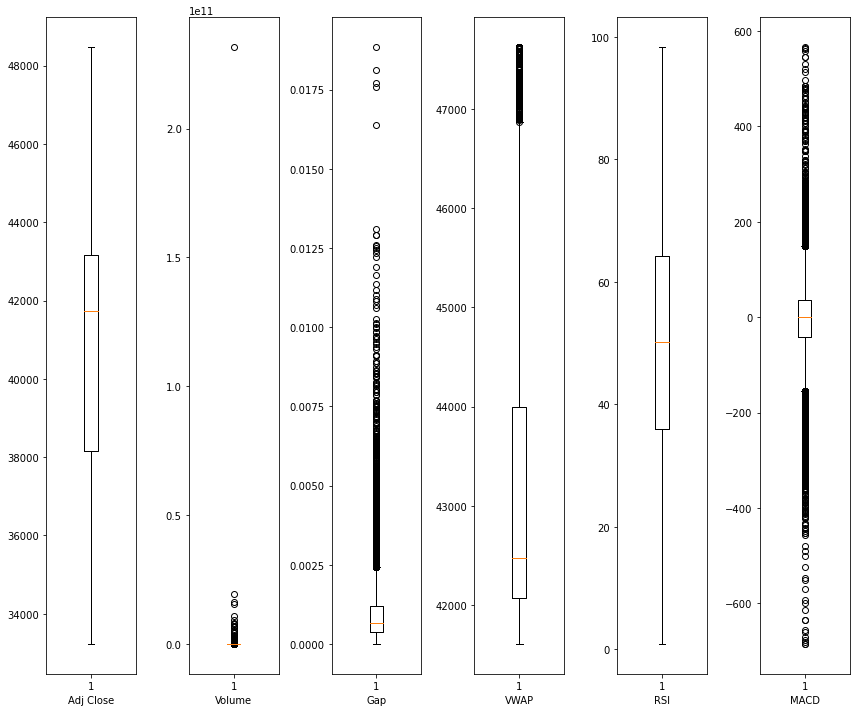

In [94]:
fig,axes = plt.subplots(1,6,figsize=(12,10))
for i, c in enumerate(df.columns,start=1):
    plt.subplot(1,6,i)
    plt.boxplot(df[c])
    plt.xlabel(c)
plt.tight_layout()

iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. gap, vwap, macd가 특히 심하다.


In [95]:
q_1 = df.apply(lambda x: np.quantile(x,0.25))
q_3 = df.apply(lambda x: np.quantile(x,0.75))
iqr = q_3 - q_1
min_p = q_1 - 2.5 * iqr
max_p = q_3 + 2.5 * iqr
print(min_p,max_p)

Adj Close    2.570284e+04
Volume      -9.448704e+07
Gap         -1.658745e-03
VWAP         3.728096e+04
RSI         -3.439178e+01
MACD        -2.302297e+02
dtype: float64 Adj Close    5.562040e+04
Volume       1.322819e+08
Gap          3.232285e-03
VWAP         4.878694e+04
RSI          1.346933e+02
MACD         2.251491e+02
dtype: float64


5분 단위 데이터라 그런지 volume이 0으로 잡히는 경우가 많다. 따라서 volume을 제외하고 이상치를 구해준다.

In [96]:
outliers = np.where((df < min_p) | (df > max_p))
outliers

(array([   15,    22,    65, ..., 17108, 17108, 17109]),
 array([1, 1, 2, ..., 1, 2, 1]))

In [97]:
len(outliers[0])

2309

In [98]:
from collections import defaultdict
row,col = outliers
outliers_cols = defaultdict(list)
for r,c in zip(row,col):
    outliers_cols[df.columns[c]].append(r)
outliers_cols

defaultdict(list,
            {'Volume': [15,
              22,
              132,
              196,
              202,
              203,
              204,
              205,
              206,
              209,
              246,
              262,
              296,
              311,
              325,
              326,
              335,
              336,
              338,
              342,
              344,
              347,
              351,
              359,
              360,
              361,
              398,
              412,
              431,
              454,
              455,
              467,
              478,
              481,
              488,
              503,
              519,
              548,
              576,
              579,
              584,
              601,
              602,
              610,
              736,
              790,
              850,
              870,
              871,
              880,
              881,
     

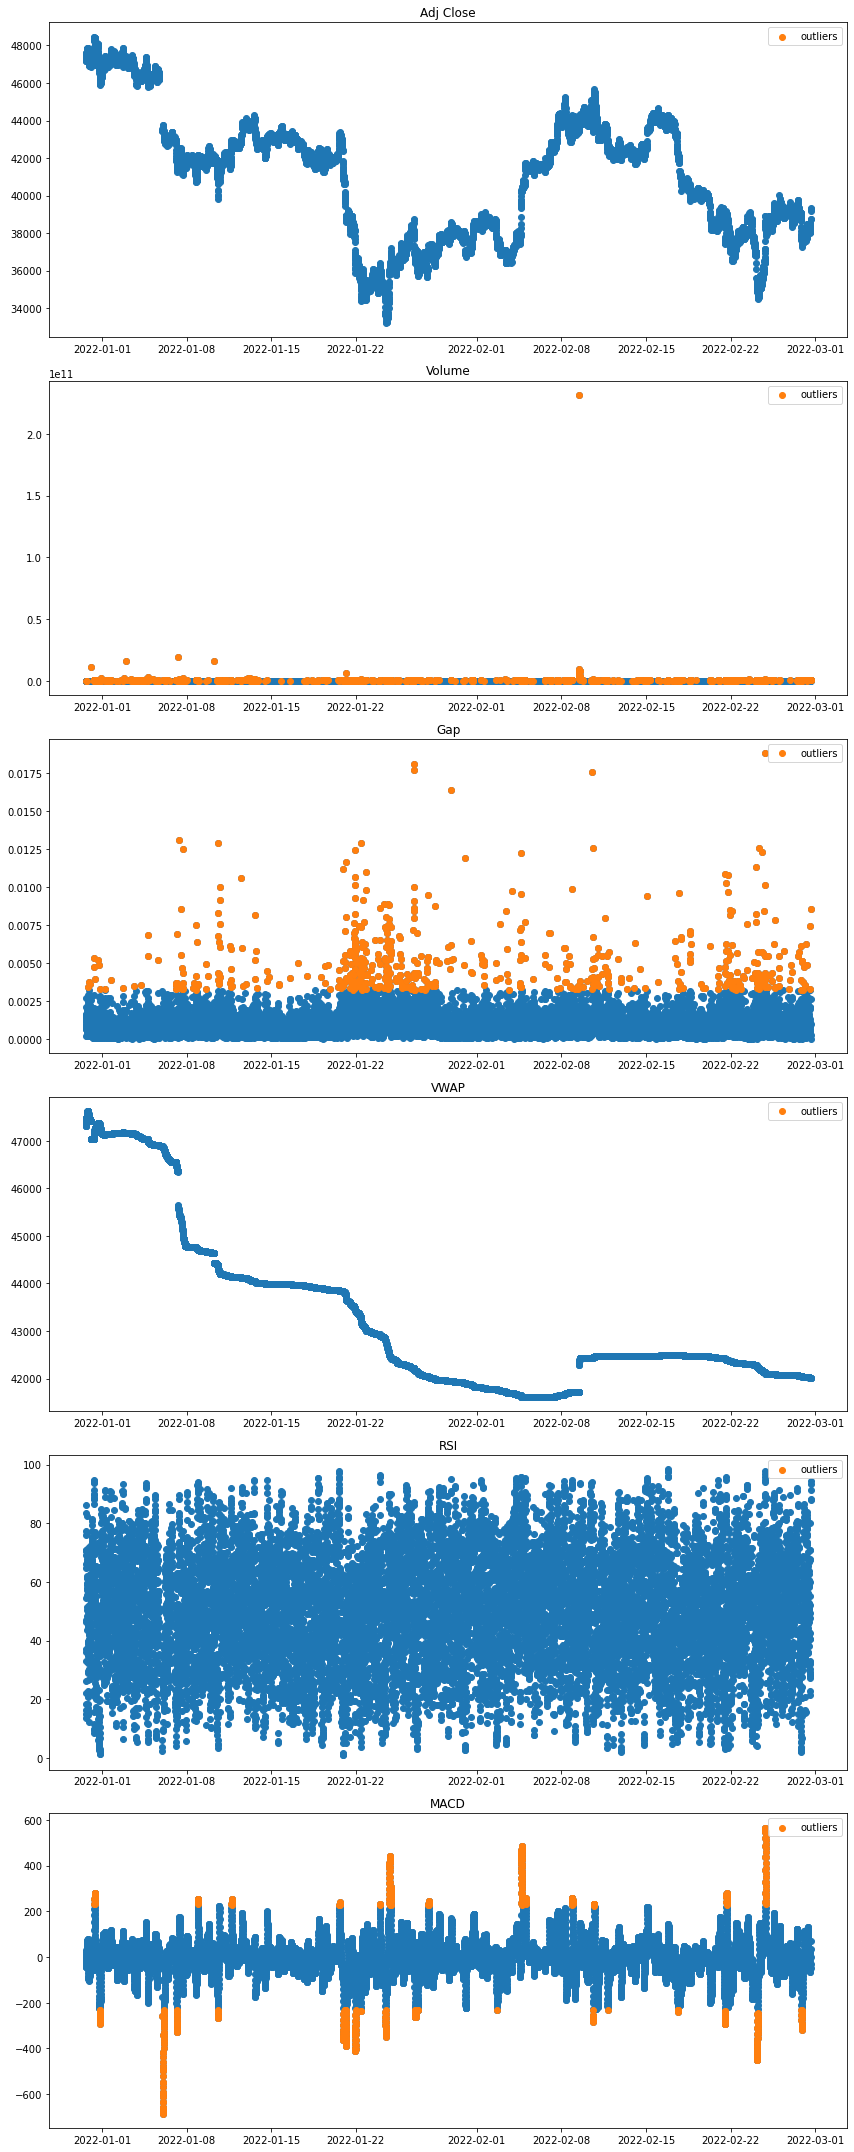

In [99]:
fig,axes = plt.subplots(6,1,figsize=(12,30))
for i, c in enumerate(df.columns,start=1):
    index = df[c].index
    plt.subplot(6,1,i)
    plt.title(c)
    plt.scatter(x=index,y=df[c])
    # if c!='Volume':
    plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
    plt.legend()
plt.tight_layout()

아웃라이어를 제거하는 것보다 포함하는 것이 5분 차트에 있어서는 더욱 예측도가 좋았다.


모델을 생성하고 비교해보자.

In [100]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Ridge(alpha=10,solver="cholesky",random_state=42))
])
lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Lasso(alpha=10,random_state=42,fit_intercept=True))
])
rf_model = Pipeline([
    ('std_scaler', StandardScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True))
])

In [101]:
def create_train_data(df):
    X = df.drop(['Adj Close','Volume'],axis=1)
    y = df['Adj Close'] #비트코인의 봉 평균가.
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=24)
    return train_X, test_X, train_y, test_y

In [102]:
train_X, test_X, train_y, test_y = create_train_data(df)

In [103]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)



mse: 5669275.915118717, alpha: 1000
mse: 5650038.8173533445, alpha: 300
mse: 5629272.545093553, alpha: 100
mse: 5597596.30843866, alpha: 30
mse: 5571676.262222067, alpha: 10
mse: 5559787.967000555, alpha: 1
mse: 7008504.029647429, alpha: 1000
mse: 5944434.5294218175, alpha: 300
mse: 5716502.24939268, alpha: 100
mse: 5663570.404893937, alpha: 30
mse: 5632554.726946996, alpha: 10


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8796899268.21856, tolerance: 12901342.283006074
  model = cd_fast.enet_coordinate_descent(


mse: 5567436.253160514, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8796899268.21856, tolerance: 12901342.283006074
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=4)),
                ('std_scaler', StandardScaler()),
                ('regulator', Lasso(alpha=1, random_state=42))])

In [104]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.1f}')
    plt.legend()

In [105]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)

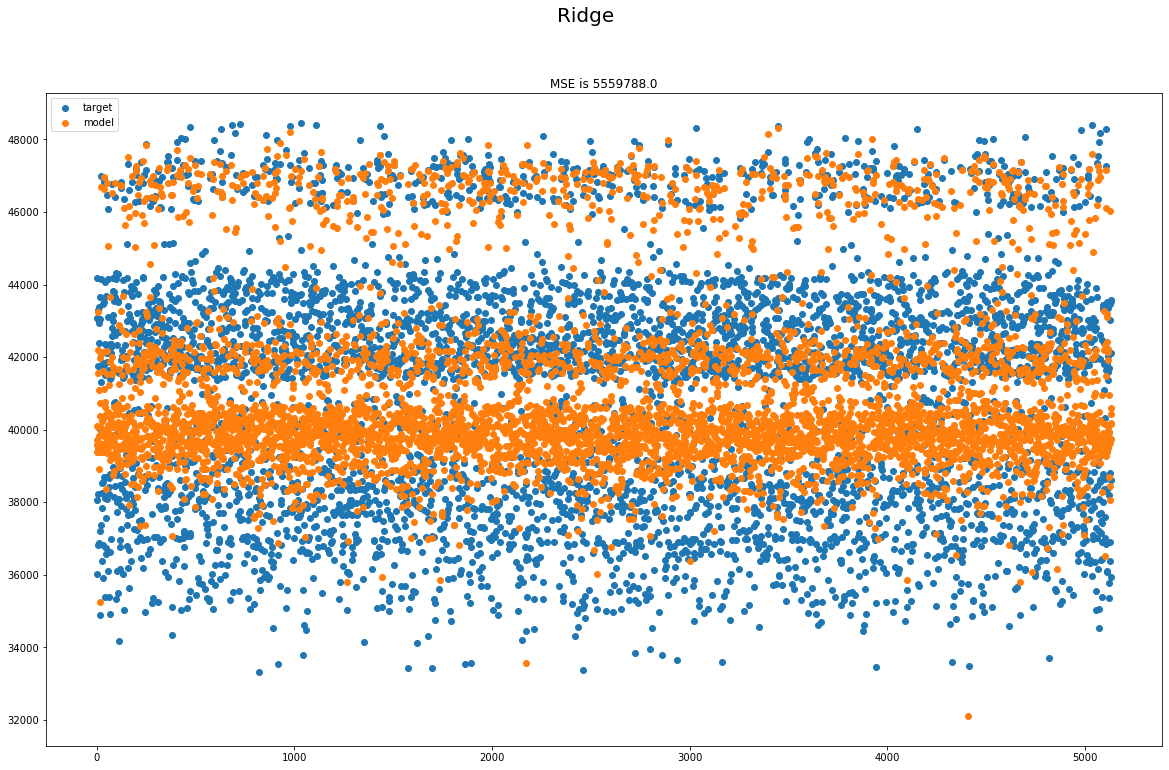

In [106]:
visualize(r_pred,test_y,"Ridge")

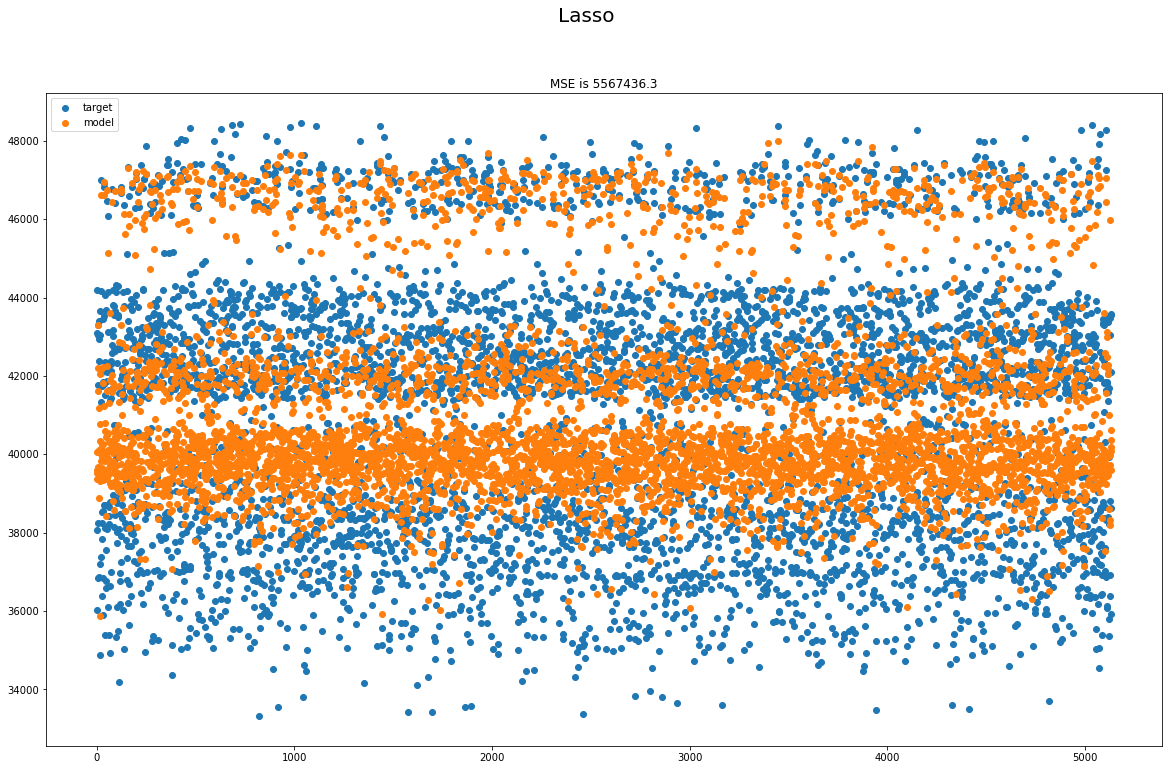

In [107]:
visualize(l_pred, test_y, "Lasso")

In [108]:
def visualize_plot(pred,target,name):
    pred = pd.Series(pred, index=target.index)
    plt.figure(figsize=(12,10))
    pred.sort_index().plot(label='model')
    test_y.sort_index().plot(label='target')
    plt.title(name)
    plt.legend()


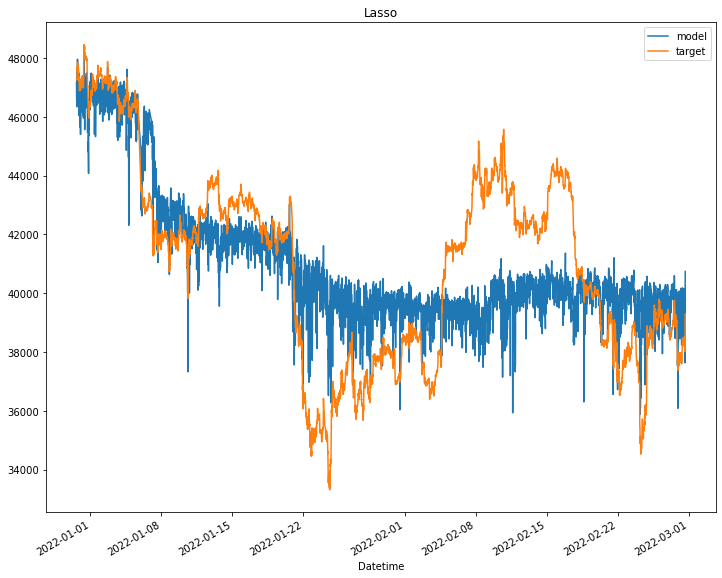

In [109]:
visualize_plot(l_pred, test_y, 'Lasso')

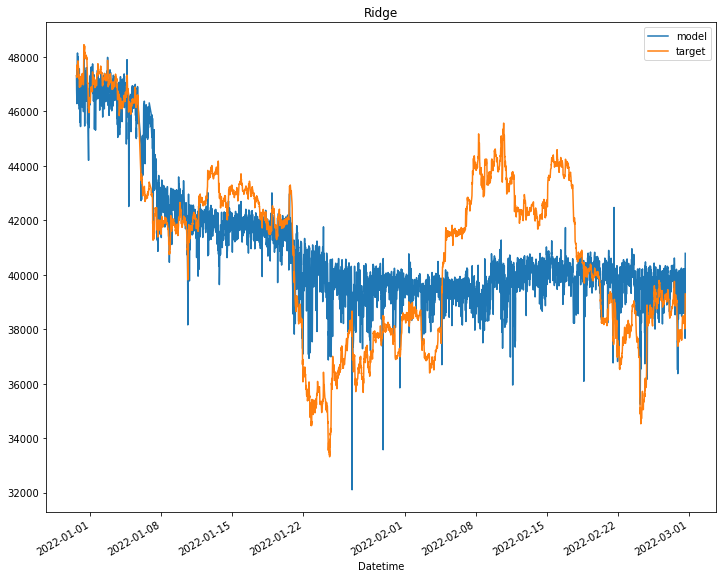

In [110]:
visualize_plot(r_pred, test_y, "Ridge")

In [111]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

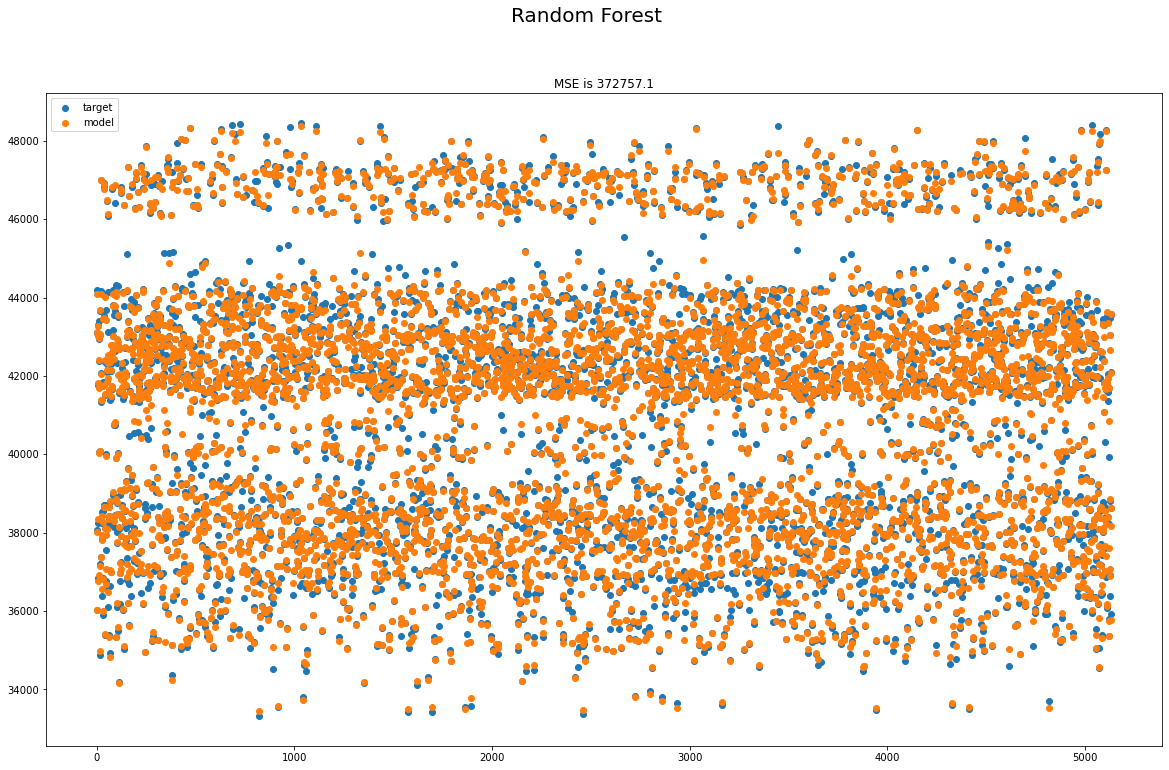

In [112]:
visualize(rf_pred, test_y, "Random Forest")

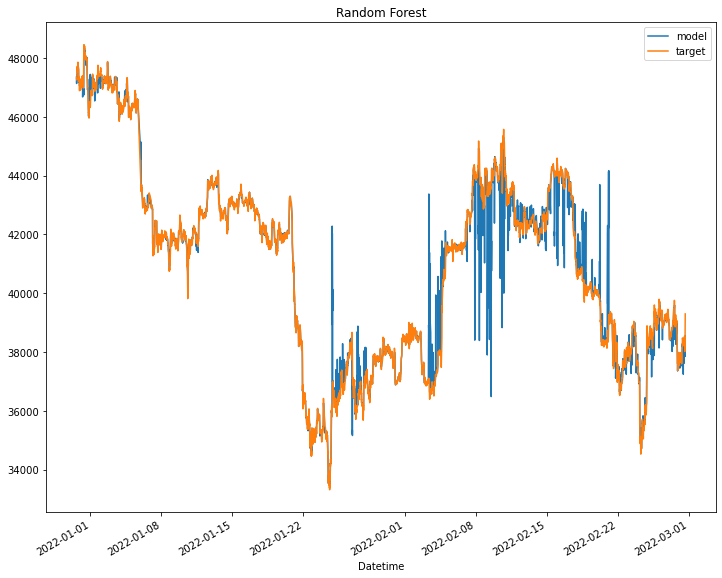

In [113]:
visualize_plot(rf_pred, test_y, "Random Forest")

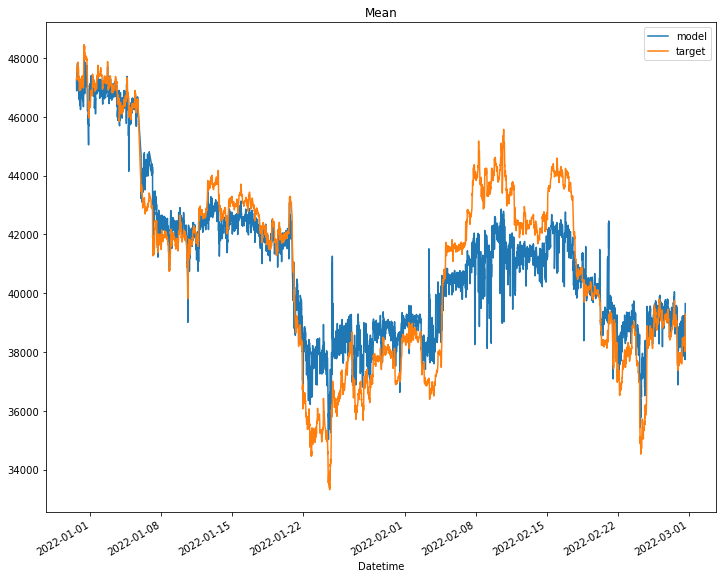

In [114]:
visualize_plot((l_pred + rf_pred)/2,test_y,"Mean")

In [115]:
v_df = df[(df.index > pd.to_datetime("2022-1-22"))& (df.index < pd.to_datetime("2022-2-27"))]
v_df

,Adj Close,Volume,Gap,VWAP,RSI,MACD
Datetime,,,,,,
2022-01-22 00:05:00,36464.214844,0,0.005231,43407.046616,46.452754,-233.121876
2022-01-22 00:10:00,36366.160156,0,0.000836,43407.046616,41.630014,-220.157530
2022-01-22 00:15:00,36333.378906,0,0.002088,43407.046616,40.009870,-209.878994
2022-01-22 00:20:00,36342.121094,96784384,0.000997,43405.246721,40.727567,-201.204858
2022-01-22 00:25:00,36434.695312,159825920,0.001593,43402.315382,48.360020,-192.055486
...,...,...,...,...,...,...
2022-02-26 23:35:00,39047.734375,0,0.000666,42073.424759,31.894327,-60.483493
2022-02-26 23:40:00,38983.304688,0,0.001242,42073.424759,24.954169,-65.194918
2022-02-26 23:45:00,39028.628906,0,0.001018,42073.424759,36.325527,-68.891725


<AxesSubplot:xlabel='Datetime'>

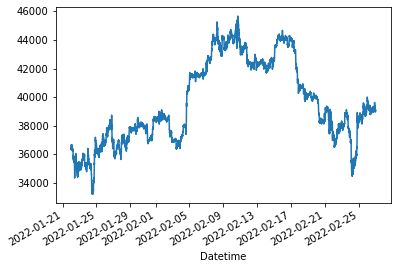

In [116]:
v_df['Adj Close'].plot()

<AxesSubplot:>

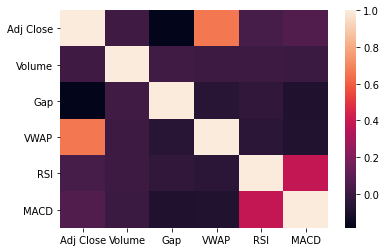

In [117]:
sns.heatmap(df.corr())

<AxesSubplot:>

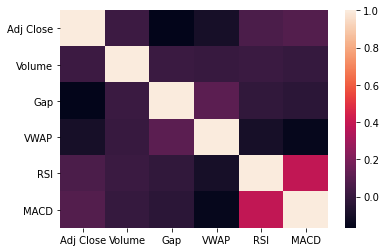

In [118]:
sns.heatmap(v_df.corr())

<AxesSubplot:xlabel='Datetime'>

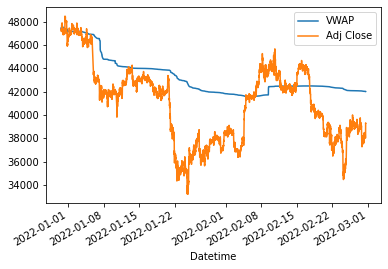

In [119]:
df[['VWAP', 'Adj Close']].plot()


<AxesSubplot:xlabel='Datetime'>

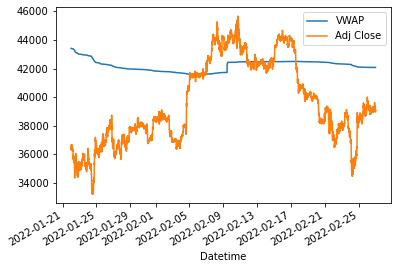

In [120]:
v_df[['VWAP', 'Adj Close']].plot()

In [121]:
from joblib import dump #모델을 저장한다.
dump(rf_model,'model/BTCUSD_RF_5m.joblib')


['model/BTCUSD_RF_5m.joblib']